In [1]:
# fastai package is required

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import * 

path = Path('data/zgt-1'); path.ls()

bs = 24
# This is what we want to flip and move around; we want to do just basic stuff at first
no_tfms = get_transforms(do_flip=False)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0)
data = ImageDataBunch.from_folder(path, ds_tfms= no_tfms, size=214, bs=bs).normalize(imagenet_stats)
# lists out the classes
data.classes
data.show_batch(rows=2, figsize=(8,8))


In [2]:
# model definition
model = densenet169
model_name = str(model).split()[1] 
def getLearner():
    return cnn_learner(data, model, pretrained=True, metrics=[accuracy, error_rate, Recall(), Precision(), FBeta()], 
callback_fns=[ShowGraph, partial(CSVLogger, append=True, filename =model_name + str('_bs:') + str(bs)),
              partial(ReduceLROnPlateauCallback,factor=0.1,min_delta=0.01, patience=3)])

learner = getLearner()
learner.load('densenet169') # load a saved model 

Learner(data=ImageDataBunch;

Train: LabelList (6952 items)
x: ImageList
Image (3, 214, 214),Image (3, 214, 214),Image (3, 214, 214),Image (3, 214, 214),Image (3, 214, 214)
y: CategoryList
no_frac,no_frac,no_frac,no_frac,no_frac
Path: data/zgt-1;

Valid: LabelList (1676 items)
x: ImageList
Image (3, 214, 214),Image (3, 214, 214),Image (3, 214, 214),Image (3, 214, 214),Image (3, 214, 214)
y: CategoryList
no_frac,no_frac,no_frac,no_frac,no_frac
Path: data/zgt-1;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

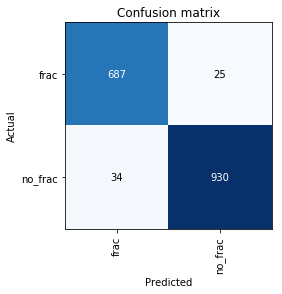

In [3]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

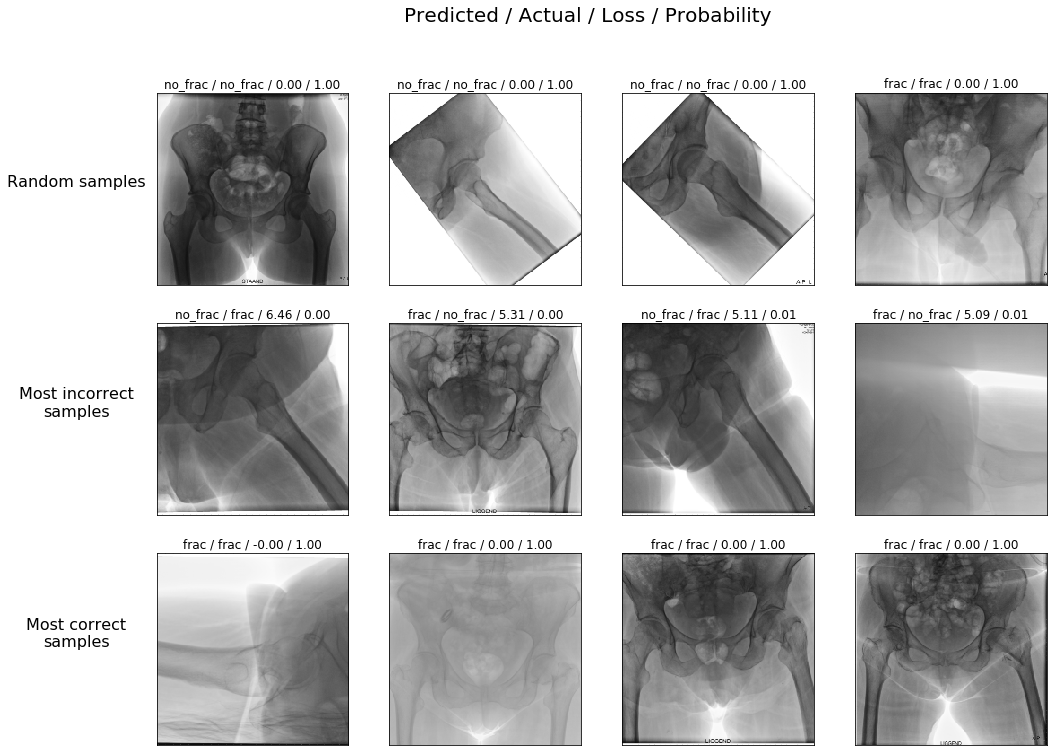

In [4]:
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['frac','no_frac']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)
        
plot_overview(interp, ['frac','no_frac'])


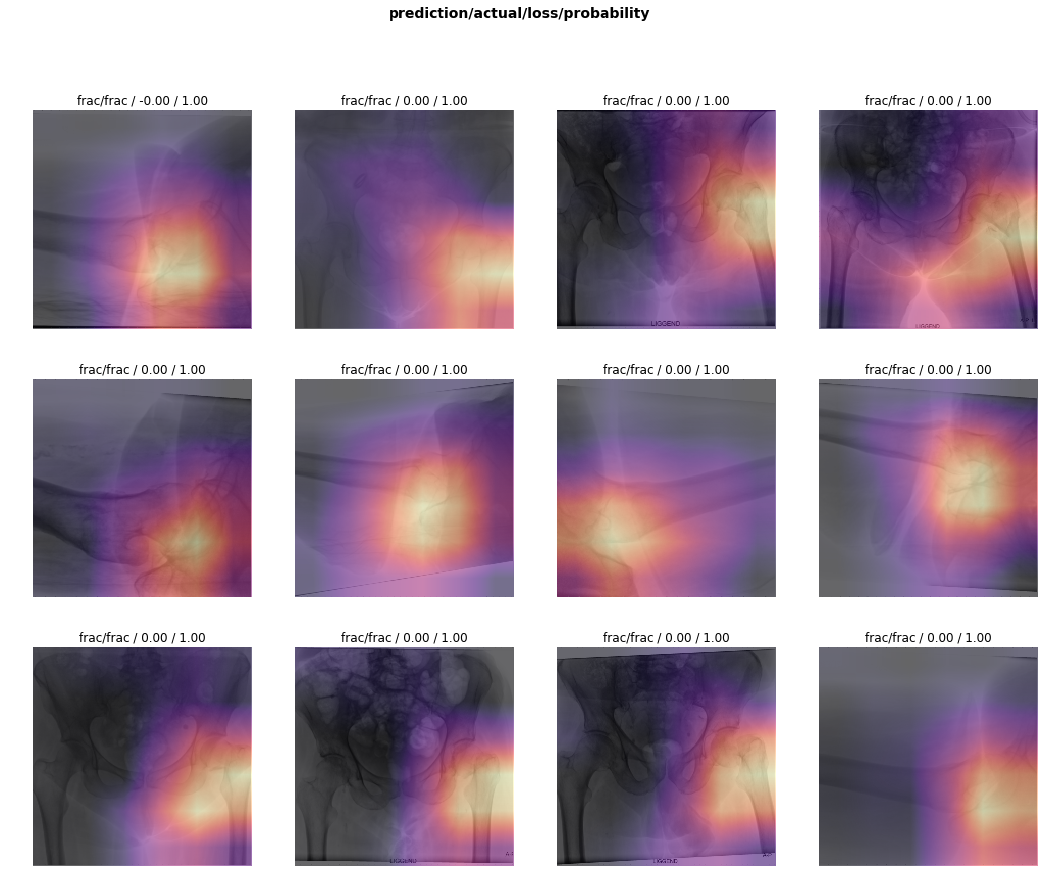

In [5]:
interp.plot_top_losses(12,largest= False,heatmap=True, figsize=(18,14))


Category no_frac

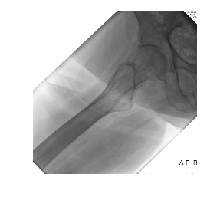

In [6]:
# random example
idx=2
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

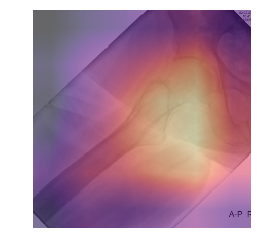

In [15]:
m = learner.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cpu()

from fastai.callbacks.hooks import *
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape
avg_acts = acts.mean(0)
avg_acts.shape

def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,212,212,0),
              interpolation='bilinear', cmap='magma');
    
show_heatmap(avg_acts)